## Setup

**Required Libraries:** pandas, numpy, matplotlib, seaborn, nflreadpy

**Installation with UV:**
```bash
# Install UV if you don't have it
curl -LsSf https://astral.sh/uv/install.sh | sh  # macOS/Linux
# OR
powershell -c "irm https://astral.sh/uv/install.ps1 | iex"  # Windows

# Install packages
uv pip install pandas numpy matplotlib seaborn nflreadpy
```

**Data Source:** nflfastR play-by-play data (2010-2025 seasons) - automatically downloaded and cached on first run via nflreadpy

# NFL Quarterback Performance Analysis (2010-2025)

## Project Overview

I wanted to create a comprehensive statistical analysis evaluating NFL quarterback performance across several seasons using advanced metrics beyond traditional box scores. This analysis identifies elite performers, situational specialists, and pocket management styles using play-by-play data.

### Analysis Goals
1. **Rank QBs by total value creation** (passing + rushing EPA)
2. **Evaluate consistency across game situations** (down, field position, score)
3. **Identify pocket management vs offensive aggressiveness trade-offs**

### Key Metrics
- **EPA (Expected Points Added)**: Context-aware metric measuring play value relative to average outcomes in similar situations
- **CPOE (Completion % Over Expected)**: Accuracy metric adjusted for throw difficulty
- **Sack Rate & Yards/Attempt**: Pocket management and offensive efficiency indicators

**Sample Size Filter:** 300+ pass attempts (ensures statistical reliability)

In [32]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nflreadpy

# Visualization config
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

print(f"pandas: {pd.__version__} | numpy: {np.__version__} | nflreadpy: {nflreadpy.__version__}")

pandas: 2.3.3 | numpy: 2.3.5 | nflreadpy: 0.1.5


## Data Acquisition

Loading 2010-2025 NFL play-by-play data from nflfastR via nflreadpy.

In [33]:
# Load 2010-2025 play-by-play data
seasons = range(2010, 2026)  # 2010-2025
pbp_list = []

for season in seasons:
    print(f"Loading {season} season...")
    pbp_season = nflreadpy.load_pbp(season).to_pandas()
    pbp_list.append(pbp_season)

pbp = pd.concat(pbp_list, ignore_index=True)

print(f"\nDataset: {pbp.shape[0]:,} plays × {pbp.shape[1]} features")
print(f"Seasons: {pbp['season'].min()}-{pbp['season'].max()}")
print(f"Plays per season:\n{pbp['season'].value_counts().sort_index()}")
display(pbp.head())

Loading 2010 season...
Loading 2011 season...
Loading 2011 season...
Loading 2012 season...
Loading 2012 season...
Loading 2013 season...
Loading 2013 season...
Loading 2014 season...
Loading 2014 season...
Loading 2015 season...
Loading 2015 season...
Loading 2016 season...
Loading 2016 season...
Loading 2017 season...
Loading 2017 season...
Loading 2018 season...
Loading 2018 season...
Loading 2019 season...
Loading 2019 season...
Loading 2020 season...
Loading 2020 season...
Loading 2021 season...
Loading 2021 season...
Loading 2022 season...
Loading 2022 season...
Loading 2023 season...
Loading 2023 season...
Loading 2024 season...
Loading 2024 season...
Loading 2025 season...
Loading 2025 season...

Dataset: 749,862 plays × 372 features
Seasons: 2010-2025
Plays per season:
season
2010    46892
2011    47448
2012    47834
2013    48158
2014    47629
2015    48122
2016    47651
2017    47245
2018    47109
2019    47260
2020    47705
2021    49922
2022    49434
2023    49665
2024    

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
0,1.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,None,None,None,...,0.0,0.0,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,0.0,0.0,0.043582,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,58.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,0.0,0.0,-0.564644,0.900138,6.992027,6.0,0.690780,0.224250,0.502033,49.796659
3,82.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,0.0,0.0,-0.022353,NaN,NaN,NaN,NaN,NaN,0.499817,-49.981695
4,103.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,1.0,0.0,2.207573,0.226114,3.390657,1.0,0.998045,0.998045,0.962868,3.713167


### Key Data Fields

- **Player identifiers**: `passer_player_name`, `rusher_player_name`
- **Play outcomes**: `epa`, `cpoe`, `complete_pass`, `yards_gained`, `air_yards`
- **Play classification**: `pass_attempt`, `rush_attempt`, `down`, `yardline_100`
- **Game context**: `score_differential`, `season`, `week`

## Data Processing & Feature Engineering

**Pipeline:**
1. Separate passing and rushing plays for all QBs
2. Aggregate statistics by quarterback (passing and rushing separately)
3. Merge datasets to combine dual-threat QB contributions
4. Calculate total EPA metrics (passing + rushing combined)
5. Derive efficiency metrics (completion %, sack rate, yards/attempt, TD:INT ratio)
6. Filter for sample size (≥300 pass attempts)

In [34]:
# Filter passing plays and calculate comprehensive QB statistics
passing_plays = pbp[pbp['pass_attempt'] == 1].copy()
passing_plays = passing_plays[passing_plays['passer_player_name'].notnull()]

# Standardize player names (fix inconsistencies in source data)
name_fixes = {
    'Aa.Rodgers': 'A.Rodgers',
}
passing_plays['passer_player_name'] = passing_plays['passer_player_name'].replace(name_fixes)

# Calculate success (positive EPA plays)
passing_plays['success'] = (passing_plays['epa'] > 0).astype(int)

print(f"Passing plays: {len(passing_plays):,} ({len(passing_plays)/len(pbp)*100:.1f}% of total)")

# Filter rushing plays for QBs (designed runs + scrambles)
rushing_plays = pbp[(pbp['rush_attempt'] == 1) & (pbp['rusher_player_name'].notnull())].copy()

# Standardize rusher names too
rushing_plays['rusher_player_name'] = rushing_plays['rusher_player_name'].replace(name_fixes)

rushing_plays['success'] = (rushing_plays['epa'] > 0).astype(int)

print(f"Rushing plays: {len(rushing_plays):,} ({len(rushing_plays)/len(pbp)*100:.1f}% of total)")

# Aggregate passing statistics BY SEASON
pass_stats = passing_plays.groupby(['passer_player_name', 'season']).agg(
    pass_attempts=('pass_attempt', 'sum'),
    completions=('complete_pass', 'sum'),
    pass_tds=('pass_touchdown', 'sum'),
    interceptions=('interception', 'sum'),
    sacks=('sack', 'sum'),
    pass_epa_total=('epa', 'sum'),
    pass_epa_mean=('epa', 'mean'),
    passing_yards=('passing_yards', 'sum'),
    air_yards_total=('air_yards', 'sum'),
    cpoe_mean=('cpoe', 'mean'),
    pass_successes=('success', 'sum')
).reset_index()

# Aggregate rushing statistics BY SEASON
rush_stats = rushing_plays.groupby(['rusher_player_name', 'season']).agg(
    rush_attempts=('rush_attempt', 'sum'),
    rush_epa_total=('epa', 'sum'),
    rush_epa_mean=('epa', 'mean'),
    rushing_yards=('rushing_yards', 'sum'),
    rush_successes=('success', 'sum')
).reset_index()
rush_stats.rename(columns={'rusher_player_name': 'passer_player_name'}, inplace=True)

# Merge passing and rushing stats
qb_stats = pass_stats.merge(rush_stats, on=['passer_player_name', 'season'], how='left')
qb_stats.fillna({'rush_attempts': 0, 'rush_epa_total': 0, 'rush_epa_mean': 0, 
                 'rushing_yards': 0, 'rush_successes': 0}, inplace=True)

# Calculate total (passing + rushing) metrics
qb_stats['total_plays'] = qb_stats['pass_attempts'] + qb_stats['rush_attempts']
qb_stats['total_epa'] = qb_stats['pass_epa_total'] + qb_stats['rush_epa_total']
qb_stats['total_epa_per_play'] = qb_stats['total_epa'] / qb_stats['total_plays']
qb_stats['total_successes'] = qb_stats['pass_successes'] + qb_stats['rush_successes']
qb_stats['total_success_rate'] = 100 * (qb_stats['total_successes'] / qb_stats['total_plays'])

# Calculate passing-only derived metrics
qb_stats['completion_pct'] = 100 * (qb_stats['completions'] / qb_stats['pass_attempts'])
qb_stats['pass_success_rate'] = 100 * (qb_stats['pass_successes'] / qb_stats['pass_attempts'])
qb_stats['td_int_ratio'] = qb_stats['pass_tds'] / qb_stats['interceptions'].replace(0, 1)
qb_stats['yards_per_attempt'] = qb_stats['passing_yards'] / qb_stats['pass_attempts']
qb_stats['sack_rate'] = 100 * (qb_stats['sacks'] / (qb_stats['pass_attempts'] + qb_stats['sacks']))
qb_stats['td_rate'] = 100 * (qb_stats['pass_tds'] / qb_stats['pass_attempts'])
qb_stats['int_rate'] = 100 * (qb_stats['interceptions'] / qb_stats['pass_attempts'])
qb_stats['air_yards_per_attempt'] = qb_stats['air_yards_total'] / qb_stats['pass_attempts']

# Filter for statistical significance (120+ pass attempts PER SEASON)
MIN_ATTEMPTS = 120
qb_stats = qb_stats[qb_stats['pass_attempts'] >= MIN_ATTEMPTS].sort_values('total_epa_per_play', ascending=False)

print(f"\nQualifying QB-seasons (≥{MIN_ATTEMPTS} pass attempts per season): {len(qb_stats)}")
print(f"Breakdown by season:")
print(qb_stats['season'].value_counts().sort_index())
print(f"\nTop 10 QB-seasons by Total EPA/Play (Passing + Rushing):")
display(qb_stats[['passer_player_name', 'season', 'pass_attempts', 'rush_attempts', 'total_plays', 
                   'pass_epa_mean', 'rush_epa_mean', 'total_epa_per_play', 'cpoe_mean']].head(10))


Passing plays: 313,419 (41.8% of total)
Rushing plays: 227,390 (30.3% of total)

Qualifying QB-seasons (≥120 pass attempts per season): 677
Breakdown by season:
season
2010    42
2011    43
2012    39
2013    44
2014    43
2015    43
2016    40
2017    44
2018    39
2019    42
2020    42
2021    41
2022    45
2023    47
2024    45
2025    38
Name: count, dtype: int64

Top 10 QB-seasons by Total EPA/Play (Passing + Rushing):
Rushing plays: 227,390 (30.3% of total)

Qualifying QB-seasons (≥120 pass attempts per season): 677
Breakdown by season:
season
2010    42
2011    43
2012    39
2013    44
2014    43
2015    43
2016    40
2017    44
2018    39
2019    42
2020    42
2021    41
2022    45
2023    47
2024    45
2025    38
Name: count, dtype: int64

Top 10 QB-seasons by Total EPA/Play (Passing + Rushing):


,passer_player_name,season,pass_attempts,rush_attempts,total_plays,pass_epa_mean,rush_epa_mean,total_epa_per_play,cpoe_mean
70,A.Rodgers,2011,588.0,67.0,655.0,0.363689,0.173980,0.344283,7.426928
859,J.McCown,2013,236.0,13.0,249.0,0.336239,0.365419,0.337762,4.872646
1283,P.Mahomes,2018,687.0,66.0,753.0,0.310430,0.262655,0.306242,3.721815
658,J.Allen,2024,587.0,131.0,718.0,0.258305,0.470699,0.297056,2.008676
1504,T.Brady,2011,757.0,52.0,809.0,0.302626,0.192989,0.295579,4.275888
765,J.Garoppolo,2017,186.0,15.0,201.0,0.309876,0.103011,0.294438,6.005949
1159,M.Ryan,2016,681.0,43.0,724.0,0.324842,-0.277215,0.289084,7.142148
79,A.Rodgers,2020,637.0,42.0,679.0,0.305476,0.012667,0.287365,6.779110
445,D.Brees,2011,798.0,26.0,824.0,0.310933,-0.524205,0.284582,7.107622
73,A.Rodgers,2014,623.0,47.0,670.0,0.268446,0.365188,0.275233,2.744653


## Visualizations

Three complementary analyses reveal different dimensions of QB performance:

**1. Total EPA vs CPOE** - Identifies QBs who create value (EPA) through accurate execution (CPOE). Credits dual-threat QBs by combining passing and rushing EPA.

**2. Situational Performance Heatmap** - Shows top 15 QBs' total EPA (passing + rushing) across game contexts. Elite QBs maintain effectiveness regardless of down, field position, or score.

**3. Sack Rate vs Yards/Attempt** - Reveals pocket management style: do QBs protect the ball and take sacks, or push downfield aggressively?

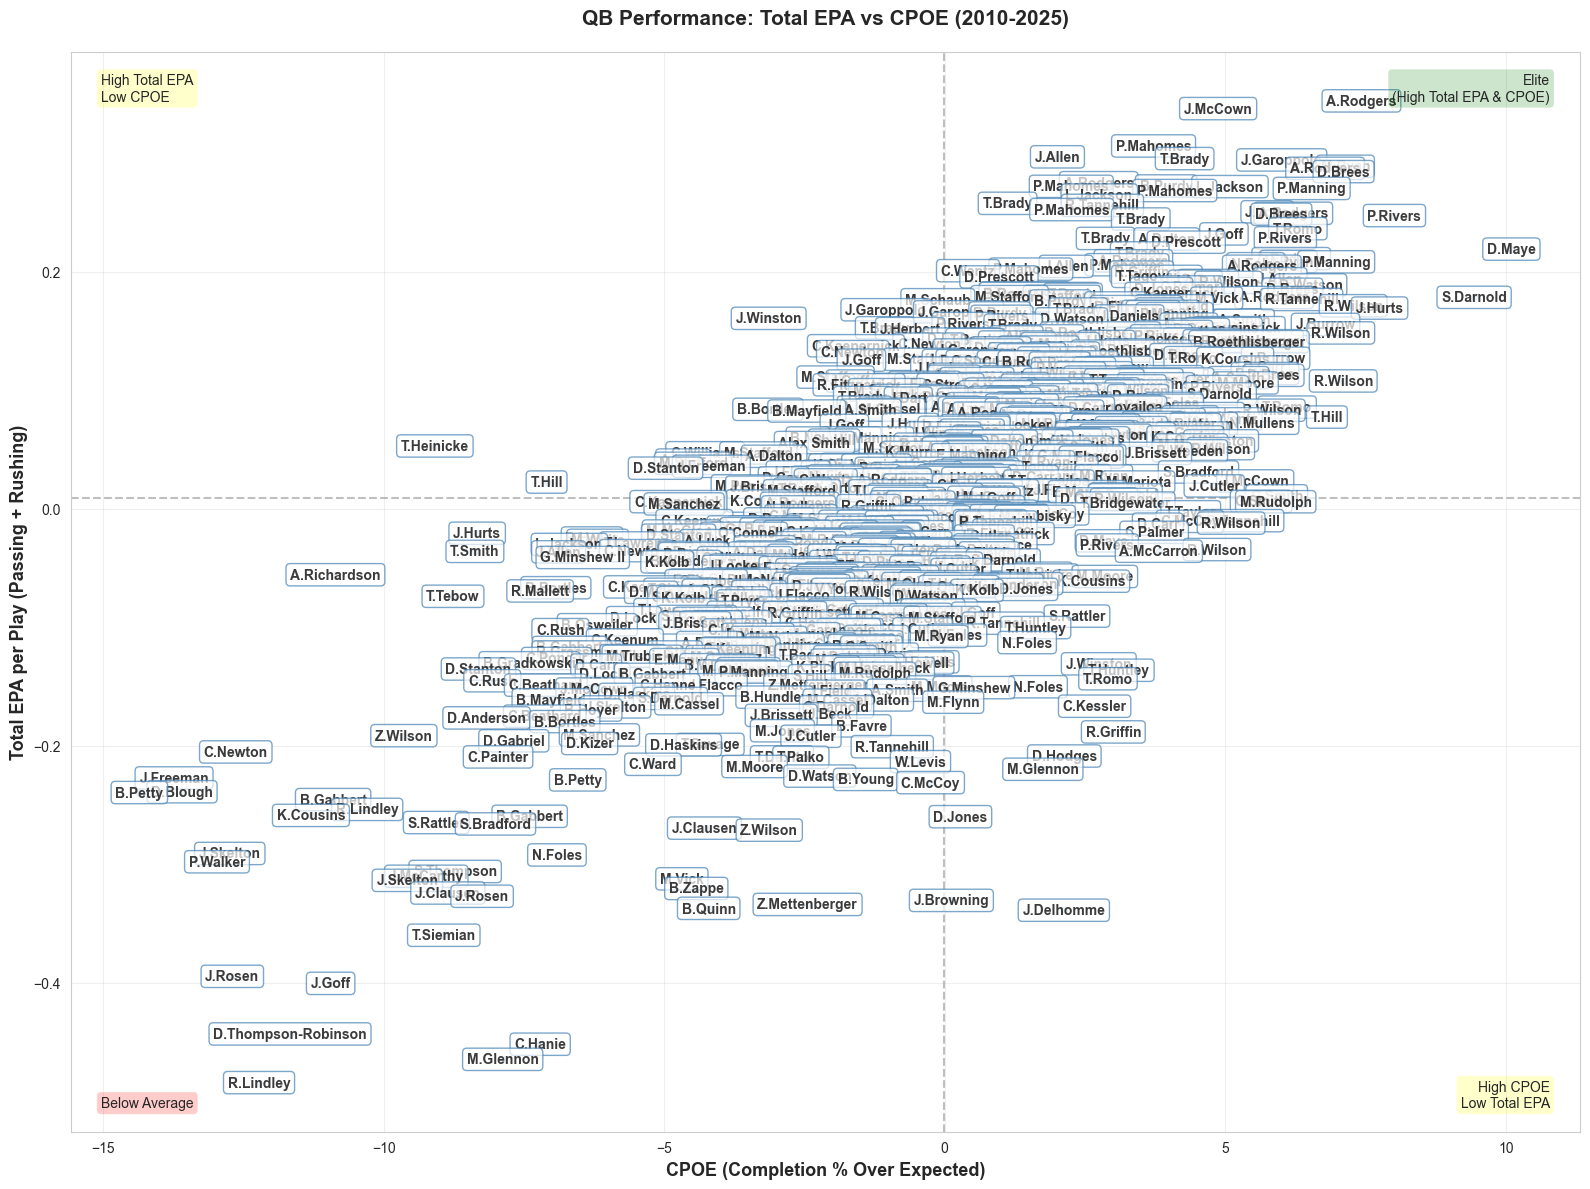


Median Total EPA/play: 0.009
Median Passing EPA/play: 0.006
Median CPOE: -0.021

Total EPA/play = (Passing EPA + Rushing EPA) / Total plays
CPOE = Completion % Over Expected (passing accuracy relative to difficulty)


In [35]:
# VISUALIZATION 1: Total EPA/Play (Pass + Rush) vs CPOE
# Y-axis = Total EPA/play (passing + rushing value), X-axis = CPOE (passing accuracy)

fig, ax = plt.subplots(figsize=(16, 12))

# Add quadrant lines
ax.axhline(y=qb_stats['total_epa_per_play'].median(), color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
ax.axvline(x=qb_stats['cpoe_mean'].median(), color='gray', linestyle='--', linewidth=1.5, alpha=0.5)

# Plot small markers for reference
ax.scatter(qb_stats['cpoe_mean'], qb_stats['total_epa_per_play'], 
           s=20, color='steelblue', alpha=0.3, zorder=1)

# Label all QBs with their names
for _, qb in qb_stats.iterrows():
    ax.text(qb['cpoe_mean'], qb['total_epa_per_play'], qb['passer_player_name'],
            fontsize=10, fontweight='bold', alpha=0.9,
            ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='steelblue', alpha=0.7, linewidth=1),
            zorder=2)

ax.set_xlabel('CPOE (Completion % Over Expected)', fontsize=13, fontweight='bold')
ax.set_ylabel('Total EPA per Play (Passing + Rushing)', fontsize=13, fontweight='bold')
ax.set_title('QB Performance: Total EPA vs CPOE (2010-2025)', 
             fontsize=15, fontweight='bold', pad=20)

# Quadrant labels
ax.text(0.98, 0.98, 'Elite\n(High Total EPA & CPOE)', 
        transform=ax.transAxes, fontsize=10, ha='right', va='top',
        bbox=dict(boxstyle='round', facecolor='green', alpha=0.2))
ax.text(0.02, 0.98, 'High Total EPA\nLow CPOE', 
        transform=ax.transAxes, fontsize=10, ha='left', va='top',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.2))
ax.text(0.98, 0.02, 'High CPOE\nLow Total EPA', 
        transform=ax.transAxes, fontsize=10, ha='right', va='bottom',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.2))
ax.text(0.02, 0.02, 'Below Average', 
        transform=ax.transAxes, fontsize=10, ha='left', va='bottom',
        bbox=dict(boxstyle='round', facecolor='red', alpha=0.2))

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nMedian Total EPA/play: {qb_stats['total_epa_per_play'].median():.3f}")
print(f"Median Passing EPA/play: {qb_stats['pass_epa_mean'].median():.3f}")
print(f"Median CPOE: {qb_stats['cpoe_mean'].median():.3f}")
print(f"\nTotal EPA/play = (Passing EPA + Rushing EPA) / Total plays")
print(f"CPOE = Completion % Over Expected (passing accuracy relative to difficulty)")

### Metric Definitions

**EPA (Expected Points Added)**

EPA measures play value by comparing the expected points before and after a play, accounting for down, distance, field position, and score.

*Example*: On 3rd-and-2 from the opponent's 30-yard line, the offense expects ~2.5 points. A 10-yard completion for a first down moves them to the 20-yard line with ~3.5 expected points → **+1.0 EPA**.

*Why it matters*: Context-aware evaluation. A 5-yard gain on 3rd-and-4 generates more EPA than a 15-yard gain on 3rd-and-20. Explosive plays and turnovers are properly weighted.

*In this analysis*: **Total EPA** combines passing and rushing to properly credit mobile QBs (Lamar Jackson, Josh Allen, Jalen Hurts).

**CPOE (Completion % Over Expected)**

CPOE measures accuracy adjusted for throw difficulty. Statistical models predict completion probability based on throw distance, receiver separation, and defensive pressure. CPOE = actual completion % minus expected completion %.

*Why it matters*: Separates QB skill from scheme. A checkdown-heavy offense may have 70% completion rate but negative CPOE. Elite QBs consistently beat completion expectations.

**Why These Together?**
- **EPA** = outcome quality (did it help the team win?)
- **CPOE** = process quality (did the QB execute the throw well?)
- Elite QBs excel at both: accurate throws that create value

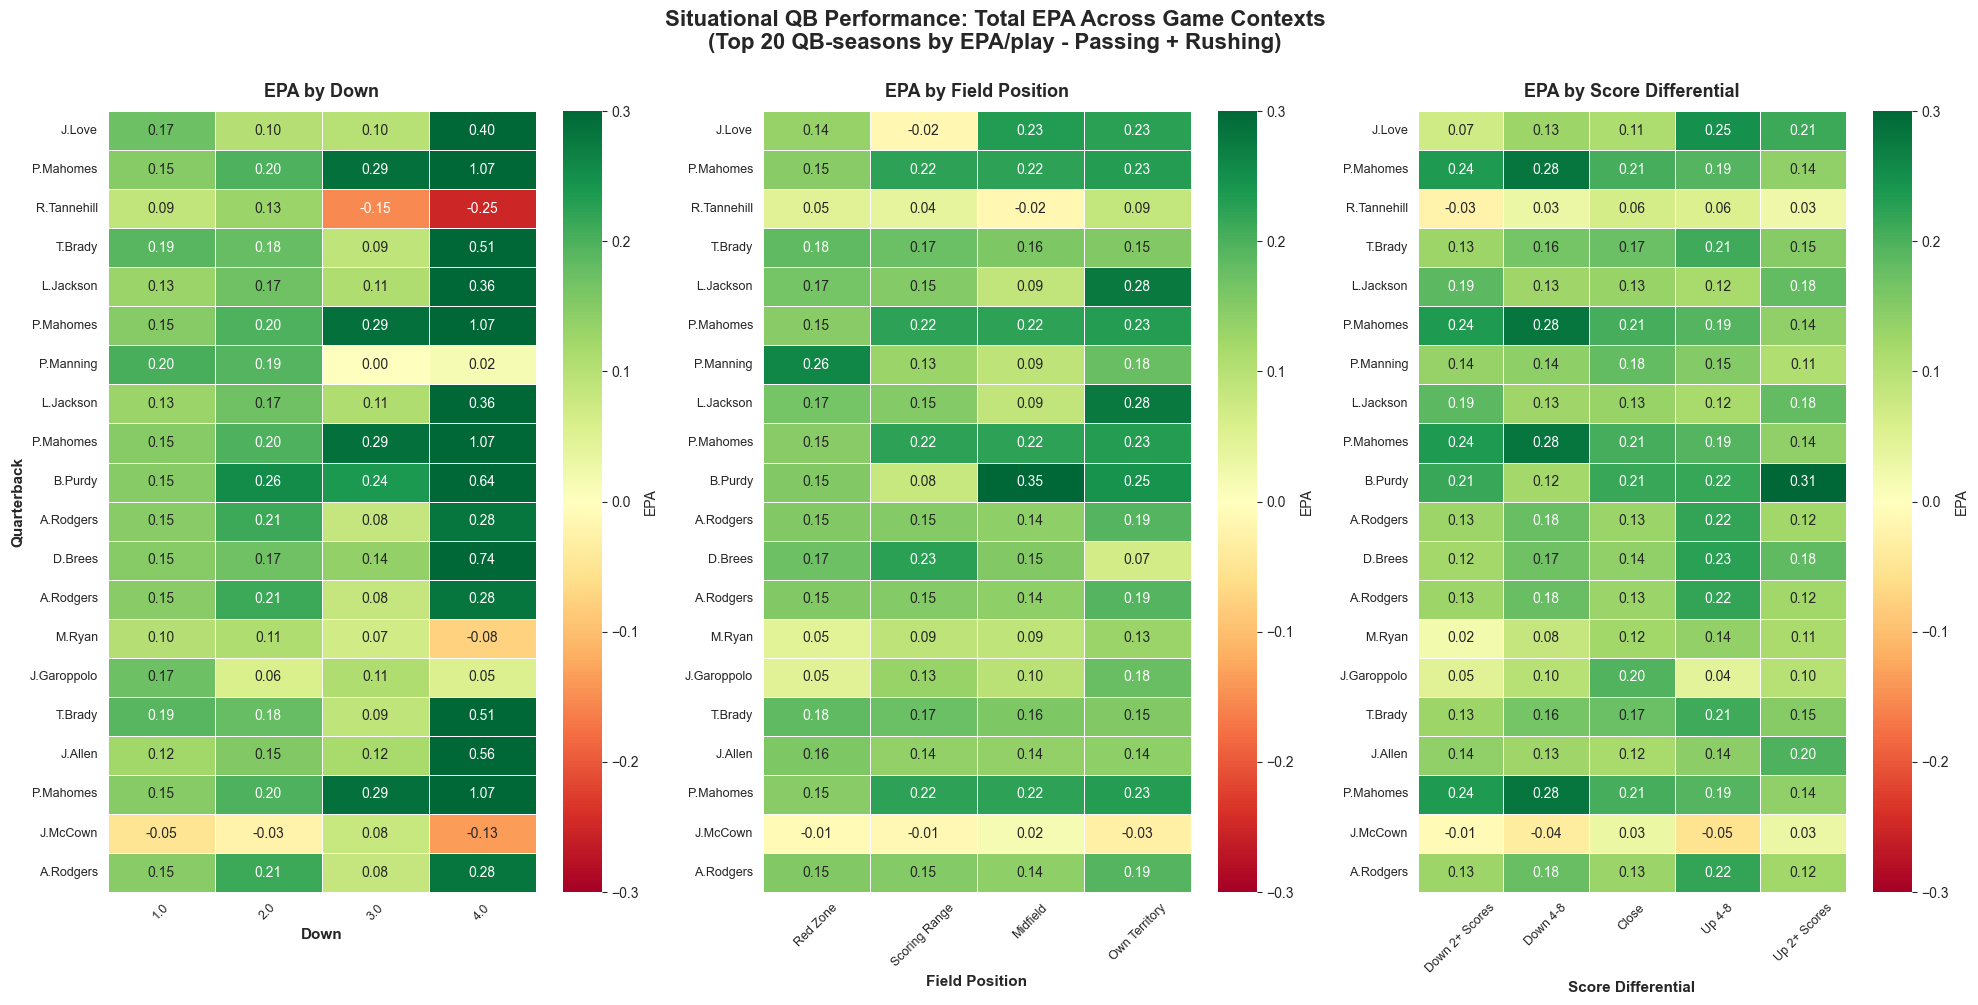


Situational Performance Insights:
  • Green = Positive EPA (effective)
  • Red = Negative EPA (ineffective)
  • Elite QBs show consistently green across all situations
  • Includes both passing and rushing EPA for complete evaluation


In [36]:
# VISUALIZATION 2: Situational Performance Heatmap
# Total EPA (passing + rushing) in different game contexts (down, field position, score differential)

# Combine passing and rushing plays for total EPA analysis
all_plays = pd.concat([passing_plays, rushing_plays[rushing_plays['rusher_player_name'].isin(qb_stats['passer_player_name'])]])

# Create situational contexts
all_plays['down'] = all_plays['down'].astype(str)
all_plays['field_zone'] = pd.cut(all_plays['yardline_100'], 
                                  bins=[0, 20, 50, 75, 100],
                                  labels=['Red Zone', 'Scoring Range', 'Midfield', 'Own Territory'])
all_plays['score_diff'] = all_plays['score_differential']
all_plays['score_situation'] = pd.cut(all_plays['score_diff'],
                                       bins=[-100, -8, -3, 3, 8, 100],
                                       labels=['Down 2+ Scores', 'Down 4-8', 'Close', 'Up 4-8', 'Up 2+ Scores'])

# Unify player name column
all_plays['qb_name'] = all_plays['passer_player_name'].fillna(all_plays['rusher_player_name'])

# For visualization: get top 20 QB-seasons by EPA for the heatmap display
top_qbs_heatmap = qb_stats.nlargest(20, 'total_epa_per_play')['passer_player_name'].tolist()
situational_context_viz = all_plays[all_plays['qb_name'].isin(top_qbs_heatmap)]

# For export: include ALL qualifying QBs (217 QB-seasons) so Streamlit can filter dynamically
situational_context = all_plays[all_plays['qb_name'].isin(qb_stats['passer_player_name'].unique())]

# Filter out plays with missing down information
situational_context_viz = situational_context_viz[situational_context_viz['down'] != 'nan']
situational_context = situational_context[situational_context['down'] != 'nan']

# Define column orders for proper left-to-right display
field_zone_order = ['Red Zone', 'Scoring Range', 'Midfield', 'Own Territory']
score_situation_order = ['Down 2+ Scores', 'Down 4-8', 'Close', 'Up 4-8', 'Up 2+ Scores']

# Calculate EPA by QB and situation
situations = ['down', 'field_zone', 'score_situation']
situation_labels = ['Down', 'Field Position', 'Score Differential']

fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for idx, (situation, label) in enumerate(zip(situations, situation_labels)):
    # Calculate mean EPA by QB and situation (use VIZ data for display)
    heatmap_data = situational_context_viz.groupby(['qb_name', situation], observed=True)['epa'].mean().unstack(fill_value=0)
    
    # Reorder columns based on situation type
    if situation == 'field_zone':
        heatmap_data = heatmap_data.reindex(columns=field_zone_order, fill_value=0)
    elif situation == 'score_situation':
        heatmap_data = heatmap_data.reindex(columns=score_situation_order, fill_value=0)
    
    # Reorder by overall EPA (inverted so best QBs at top)
    qb_order = [qb for qb in top_qbs_heatmap if qb in heatmap_data.index]
    heatmap_data = heatmap_data.loc[qb_order[::-1]]  # Reverse order
    
    # Create heatmap
    sns.heatmap(heatmap_data, ax=axes[idx], cmap='RdYlGn', center=0, 
                vmin=-0.3, vmax=0.3, annot=True, fmt='.2f',
                cbar_kws={'label': 'EPA'}, linewidths=0.5)
    
    axes[idx].set_title(f'EPA by {label}', fontsize=13, fontweight='bold', pad=10)
    axes[idx].set_xlabel(label, fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Quarterback' if idx == 0 else '', fontsize=11, fontweight='bold')
    axes[idx].tick_params(axis='y', labelsize=9)
    axes[idx].tick_params(axis='x', labelsize=9, rotation=45)

plt.suptitle('Situational QB Performance: Total EPA Across Game Contexts\n(Top 20 QB-seasons by EPA/play - Passing + Rushing)', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\nSituational Performance Insights:")
print(f"  • Green = Positive EPA (effective)")
print(f"  • Red = Negative EPA (ineffective)")
print(f"  • Elite QBs show consistently green across all situations")
print(f"  • Includes both passing and rushing EPA for complete evaluation")


In [37]:
# Export situational heatmap data for Streamlit dashboard (NOW WITH SEASON)
situational_export = situational_context.groupby(['qb_name', 'season', 'down', 'field_zone', 'score_situation'], observed=True)['epa'].mean().reset_index()
situational_export.to_csv('situational_epa_top20.csv', index=False)
print(f"Exported situational EPA data: {len(situational_export)} rows")
print(f"QBs included: {sorted(situational_export['qb_name'].unique())}")
print(f"\nBreakdown by season:")
print(situational_export['season'].value_counts().sort_index())

Exported situational EPA data: 47228 rows
QBs included: ['A.Dalton', 'A.Davis', 'A.Luck', 'A.McCarron', "A.O'Connell", 'A.Richardson', 'A.Rodgers', 'A.Smith', 'Alex Smith', 'B.Allen', 'B.Bortles', 'B.Favre', 'B.Gabbert', 'B.Gradkowski', 'B.Hoyer', 'B.Hundley', 'B.Mayfield', 'B.Nix', 'B.Osweiler', 'B.Petty', 'B.Purdy', 'B.Quinn', 'B.Roethlisberger', 'B.Weeden', 'B.Young', 'B.Zappe', 'C.Beathard', 'C.Hanie', 'C.Henne', 'C.Kaepernick', 'C.Keenum', 'C.Kessler', 'C.McCoy', 'C.Newton', 'C.Painter', 'C.Palmer', 'C.Ponder', 'C.Rush', 'C.Stroud', 'C.Ward', 'C.Wentz', 'C.Whitehurst', 'C.Williams', 'D.Anderson', 'D.Blough', 'D.Brees', 'D.Carr', 'D.Gabriel', 'D.Garrard', 'D.Haskins', 'D.Hodges', 'D.Jones', 'D.Kizer', 'D.Lock', 'D.Maye', 'D.McNabb', 'D.Mills', 'D.Orlovsky', 'D.Prescott', 'D.Ridder', 'D.Stanton', 'D.Thompson-Robinson', 'D.Watson', 'E.Manning', 'E.Manuel', 'E.Stick', 'G.Minshew', 'G.Minshew II', 'G.Smith', 'J.Allen', 'J.Beck', 'J.Brissett', 'J.Browning', 'J.Burrow', 'J.Campbell', 'J.

## Results & Interpretation

### What These Visualizations Reveal

**Visualization 1: Total EPA vs CPOE**
- Upper-right quadrant = Elite tier (high value + accurate execution)
- Upper-left = Value creators with lower accuracy (often mobile QBs)
- Lower-right = Accurate but limited value generation
- Combines passing and rushing EPA to properly evaluate dual-threat QBs

**Visualization 2: Situational Heatmap**
- Green cells = effective total EPA in that context
- Red cells = struggles in specific situations
- Elite QBs show green across all contexts (consistent regardless of game state)
- Reveals situational specialists vs all-around performers
- Includes both passing and rushing EPA for complete evaluation

**Visualization 3: Sack Rate vs Yards/Attempt**
- Upper-right = Elite (avoids sacks while pushing downfield)
- Upper-left = Aggressive style (takes sacks but generates yards)
- Lower-right = Conservative (protects ball but limited explosiveness)
- Lower-left = High risk (sacks + low production)

### Performance Profile Examples
- **Elite All-Around**: Top-right in all three charts, green heatmap
- **Efficient Pocket Passer**: High EPA/CPOE, green in clean pockets, low sack rate
- **Dual-Threat Specialist**: High total EPA (rushing boost), green on early downs
- **System QB**: High CPOE but limited EPA, struggles when script breaks down

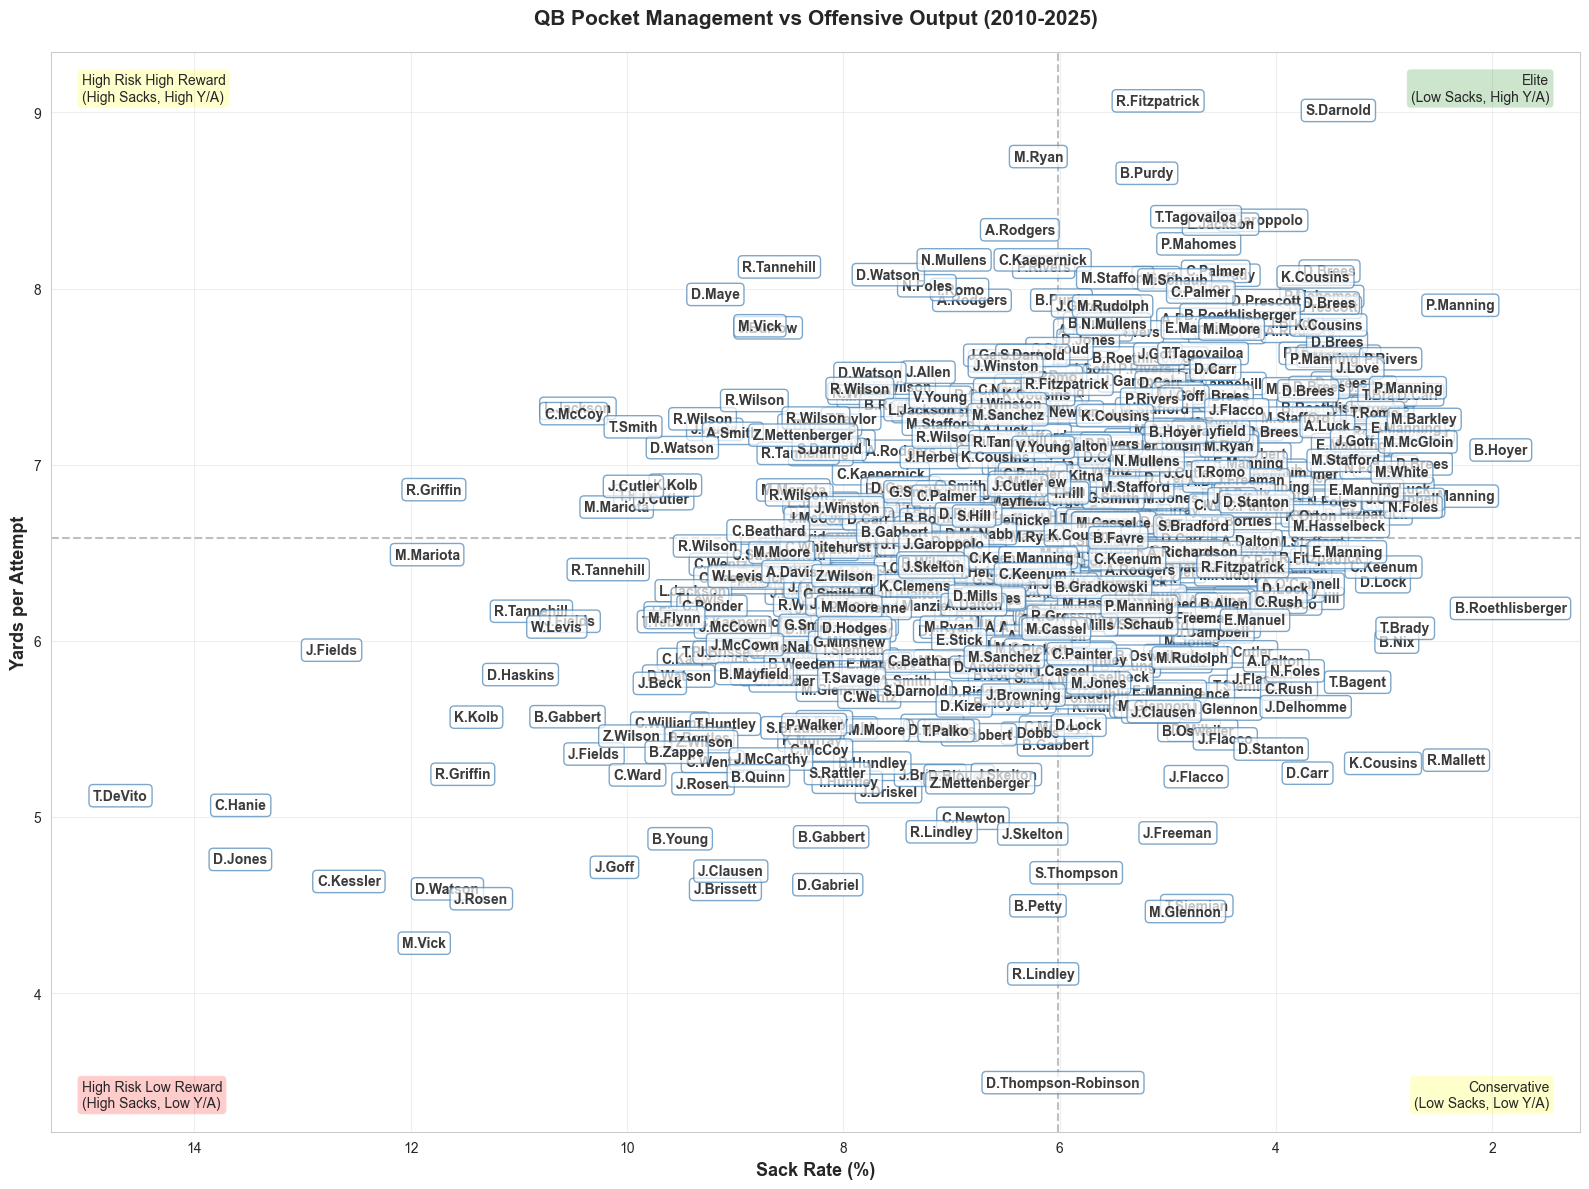


Median Sack Rate: 6.02%
Median Yards/Attempt: 6.58

Interpretation:
  • Upper-left quadrant = Elite (low sacks, high yards)
  • Upper-right quadrant = Struggling (high sacks, high yards - taking risks)
  • Lower-left quadrant = Conservative (low sacks, low yards - safe but limited)
  • Lower-right quadrant = High Risk (high sacks, low yards - worst of both)
  • Sack Rate = Sacks / (Pass Attempts + Sacks)
  • Y/A measures downfield aggressiveness and completion efficiency combined


In [38]:
# VISUALIZATION 3: Sack Rate vs Yards per Attempt
# X-axis = Sack Rate (pocket awareness), Y-axis = Yards/Attempt (aggressiveness)

fig, ax = plt.subplots(figsize=(16, 12))

# Add quadrant lines
ax.axhline(y=qb_stats['yards_per_attempt'].median(), color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
ax.axvline(x=qb_stats['sack_rate'].median(), color='gray', linestyle='--', linewidth=1.5, alpha=0.5)

# Plot small markers for reference
ax.scatter(qb_stats['sack_rate'], qb_stats['yards_per_attempt'], 
           s=20, color='steelblue', alpha=0.3, zorder=1)

# Label all QBs with their names
for _, qb in qb_stats.iterrows():
    ax.text(qb['sack_rate'], qb['yards_per_attempt'], qb['passer_player_name'],
            fontsize=10, fontweight='bold', alpha=0.9,
            ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='steelblue', alpha=0.7, linewidth=1),
            zorder=2)

ax.set_xlabel('Sack Rate (%)', fontsize=13, fontweight='bold')
ax.set_ylabel('Yards per Attempt', fontsize=13, fontweight='bold')
ax.set_title('QB Pocket Management vs Offensive Output (2010-2025)', 
             fontsize=15, fontweight='bold', pad=20)

# Quadrant labels
ax.text(0.98, 0.98, 'Elite\n(Low Sacks, High Y/A)', 
        transform=ax.transAxes, fontsize=10, ha='right', va='top',
        bbox=dict(boxstyle='round', facecolor='green', alpha=0.2))
ax.text(0.02, 0.98, 'High Risk High Reward\n(High Sacks, High Y/A)', 
        transform=ax.transAxes, fontsize=10, ha='left', va='top',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.2))
ax.text(0.98, 0.02, 'Conservative\n(Low Sacks, Low Y/A)', 
        transform=ax.transAxes, fontsize=10, ha='right', va='bottom',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.2))
ax.text(0.02, 0.02, 'High Risk Low Reward\n(High Sacks, Low Y/A)', 
        transform=ax.transAxes, fontsize=10, ha='left', va='bottom',
        bbox=dict(boxstyle='round', facecolor='red', alpha=0.2))

ax.grid(True, alpha=0.3)

# Invert X-axis so lower sack rate (better) appears on the right
ax.invert_xaxis()

plt.tight_layout()
plt.show()

print(f"\nMedian Sack Rate: {qb_stats['sack_rate'].median():.2f}%")
print(f"Median Yards/Attempt: {qb_stats['yards_per_attempt'].median():.2f}")
print(f"\nInterpretation:")
print(f"  • Upper-left quadrant = Elite (low sacks, high yards)")
print(f"  • Upper-right quadrant = Struggling (high sacks, high yards - taking risks)")
print(f"  • Lower-left quadrant = Conservative (low sacks, low yards - safe but limited)")
print(f"  • Lower-right quadrant = High Risk (high sacks, low yards - worst of both)")
print(f"  • Sack Rate = Sacks / (Pass Attempts + Sacks)")
print(f"  • Y/A measures downfield aggressiveness and completion efficiency combined")
